In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 

In [ ]:
def invert (X):
    for i in range(len(X)):
        X[i] = - X[i]
    return X

In [ ]:
def graph(X1, Y1, X2, Y2, X3, Y3, X4, Y4, X5, Y5, X6, Y6):
    fig, ax = plt.subplots(nrows= 1, ncols=1)

    plt.plot(invert(X1), Y1, label='53.5mV', linewidth=0.8)
    ax.scatter(X1, Y1)

    plt.plot(invert(X2), Y2, label='54mV', linewidth=0.8)
    ax.scatter(X2, Y2)

    plt.plot(invert(X3), Y3, label='54.5mV',linewidth=0.8)
    ax.scatter(X3, Y3)
    
    plt.plot(invert(X5), Y5, label='55mV',linewidth=0.8)
    ax.scatter(X5, Y5)
    
    plt.plot(invert(X6), Y6, label='55.5mV',linewidth=0.8)
    ax.scatter(X6, Y6)

    ax.set_yscale ("log")
    ax.set_xlabel("Threshold[mV]")
    ax.set_ylabel("Log(Frequency[kHz])")
    ax.legend()
    plt.grid()
    plt.savefig("Staircase_Finale.png")
    plt.show()
   

In [35]:
def cut_0(X, Y):
    X1 = []
    Y1 = []
    for i in range(len(X)):
        if X[i] != 0:
            X1.append(X[i])
            Y1.append(Y[i])
    return Y1, X1

[np.float64(0.421933), np.float64(0.248167), np.float64(0.170433), np.float64(0.0392333), np.float64(0.00166667), np.float64(0.000666667), np.float64(0.000566667), np.float64(6.67e-05), np.float64(6.67e-05)]


TypeError: bad operand type for unary -: 'list'

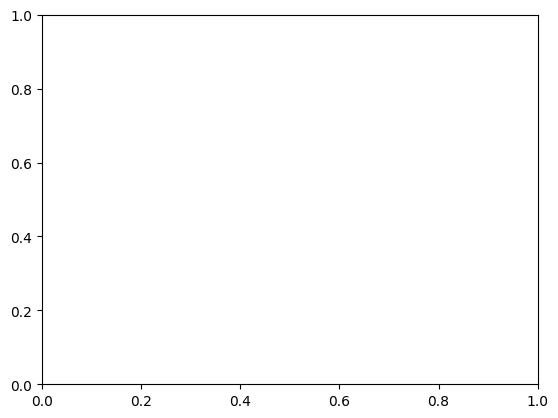

In [36]:
Z = pd.read_csv("staircase_plot_bello.CSV")
Y = Z["Th [mV] V_B 53_5V "]
K1 = cut_0(Z["F [kHz] V_B 53_5V"], Y)
K2 = cut_0(Z["F [kHz] V_B 54V"], Y)
K3 = cut_0(Z["F [kHz] V_B 54_5V"], Y)
K4 = cut_0(Z["F [kHz] V_B 55V"], Y)
K5 = cut_0(Z["F [kHz] V_B 55_5V"], Y)
K6 = cut_0(Z["F [kHz] V_B 56V"], Y)

print(K1[1])

graph(K1[0], K1[1], K2[0], K2[1], K3[0], K3[1], K4[0], K4[1], K5[0], K5[1], K6[0], K6[1])